# Assigning HF & EF demand to clusters
<br>

**Conceptualization, Methodology & Code:** [Alexandros Korkovelos](https://github.com/akorkovelos), [Andreas Sahlberg](https://github.com/AndreasSahlberg) <br> **Supervision, Review and Advisory support:** [Nishan Narayan](x) <br> **Funding:** SEforALL, GEAPP, Enabel


# Step 1. Setting up python env & Importing datasets

## Import necessary modules

As part of any modeling exercise in jupyter, the first step requires that the necessary python modules are imported. You may refer to the [requirements.txt]() to check dependencies for this notebook.

In [1]:
# Import python modules
import geopandas as gpd
import pandas as pd
import pyproj
import numpy as np
from sklearn.neighbors import BallTree
import numpy as np
from itertools import chain

import datetime

from functools import reduce
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import nearest_points

#import datapane as dp
# !datapane login --token="yourpersonaltoken"
from tkinter import filedialog, messagebox, Listbox

import folium
from folium.features import GeoJsonTooltip
import branca.colormap as cm
import os
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline

## Importing datasets

Here we import the datasets that we are going to work with. These include the following three:

**1. Administrative boundaries (vector polygon):** This defines the boundary box over our area of interest. In this example, we use the administrative boundaries of Mozambique. You may retrieve this from [GADM](https://gadm.org/) 

**2. Locations of health facilities (vector points)**: In this case we use a spatial database of health facilities that has been prepared by collecting and merging different available sources for Mozambique.

**3. Population clusters (vector polygons)**: This refers to a vectorized version of built-up areas as described and developed by [Korkovelos et al.](https://www.mdpi.com/1996-1073/12/7/1395). In this exercise, we use a custom population cluster layer created for Mozambique.
<br>

> **Note 1**. For this exercise, both (2) and (3) have been clipped based on (1) before being imported into the notebook. You may used [geopandas](https://geopandas.org/reference/geopandas.clip.html) or [Qgis](https://docs.qgis.org/2.8/en/docs/user_manual/processing_algs/gdalogr/ogr_geoprocessing/clipvectorsbypolygon.html) to do this.

> **Note 2**. All datasets are in WGS84 coordinate systems before importing. Please ensure that this is the case and correct if otherwise.

### Importing admin boundary as geodataframe

In [2]:
## Define path and name of the file
messagebox.showinfo('OnSSET - Post analysis', 'Select the admin boundaries')
admin_path = filedialog.askopenfilename(filetypes = (("vector",["*.shp", "*.gpkg", "*.geojson"]),("all files","*.*")))

# Create a new geo-dataframe
admin_gdf = gpd.read_file(admin_path)

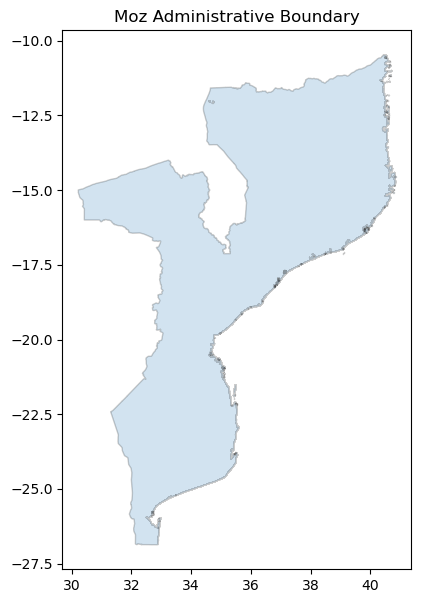

In [3]:
# Create the axis first
fig, ax = plt.subplots(figsize=(7, 7))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
ax.set_aspect('equal', 'box')
txt = ax.set_title('Moz Administrative Boundary'.format(""))
plt.show()

### Importing health facilities 

**Note** that for the code below to work properly this should be a "Point" layer; in case the geometry is characterized as "Multipoint" you should convert it into a "Point" to proceed. You may use [Qgis](http://www.saga-gis.org/saga_tool_doc/3.0.0/shapes_points_15.html) to do this.

In [4]:
## Define the path and name of the file
messagebox.showinfo('OnSSET - post analysis', 'Select csv file with Health Facilities')
health_path = filedialog.askopenfilename(filetypes = (("points",["*.csv"]),("all files","*.*")))

# Create a new geo-dataframe
health_df = pd.read_csv(health_path)

In [5]:
print ("There are {} health facilities in the file you provided. Here is a preview:\n".format(health_df.shape[0]))
health_df.head(2)

There are 1765 health facilities in the file you provided. Here is a preview:



,HF ID,uid_Q001,Name,Name (clean),Name (GPKG),MISAU--nome,Lat,Lon,MISAU--LAT,MISAU--LON,...,Prioritized,MISAU--ID,MISAU--CP,MISAU--CD,MISAU--CUUS,MISAU--CT,MISAU--CMB,MISAU--Unidade_Sa,MISAU--Classifica,MISAU--CNE
0,288,1021511.0,CS Quionga ...,Quionga,Quionga,Centro de Saude Rural II Quionga,-10.5928,40.5078,-10.5928,40.5078,...,False,258.0,2.0,15.0,US-MOZ-00258,1021511.0,1021511.0,Quionga,CS RUR.II,NU-124
1,283,1021506.0,CS Palma ...,Palma,Palma,Centro de Saude Rural II Palma,-10.7808,40.4731,-10.7808,40.4731,...,False,259.0,2.0,15.0,US-MOZ-00259,1021506.0,1021506.0,Palma,CS RUR.II,NU-124


### Convert to a geodataframe

In [6]:
health_gdf = gpd.GeoDataFrame(health_df, geometry=gpd.points_from_xy(health_df.Lon,
                                                                     health_df.Lat))

### Identify HFs that require intervention

- Currently un-electrified OR
- Currently electrified but low demand type OR
- Currently electrified but low service quality

and

- Have coordinates 

In [7]:
health_gdf_geotagged = health_gdf[health_gdf.Lat.notnull()]

health_gdf_geotagged_selected = health_gdf_geotagged[(health_gdf_geotagged["Electrified"] > 1) | 
                               ((health_gdf_geotagged["Electrified"] == 1) & ((health_gdf_geotagged["Type of demand"] < 4) | (health_gdf_geotagged["Type of demand"] == 99))) |
                               ((health_gdf_geotagged["Electrified"] == 1) & (health_gdf_geotagged["Service quality"] > 1))]

In [8]:
print ("With coordinates are:", health_gdf_geotagged.shape[0])
print ("HFs that fulfill these requirements are:", health_gdf_geotagged_selected.shape[0])

With coordinates are: 1656
HFs that fulfill these requirements are: 799


In [9]:
## Run this if you want to include only facilities that require intervention, else omit
health_gdf = health_gdf_geotagged ## or health_df_geotagged_selected

In [10]:
## Keep only the few columns needed for the estimation of demand and merging to clusters
health_gdf = health_gdf[["uid_Q001","Province", "District", "HF ID", "Facility Type", "geometry"]]

In [11]:
health_gdf["Facility Type"].unique()

array(['Centro de Saude Rural II', 'Centro de Saude Rural I',
       'Hospital Rural', 'Health post', nan, 'Posto de Saude',
       'Centro de Saude Urban C', 'Hospital Provincial',
       'Centro de Saude Urban B', 'Hospital District',
       'Centro de Saude Urban A', 'Health Centre', 'Hospital Militar',
       'Centro de Saude mental', 'Hospital General', 'Hospital Central',
       'Hospital Psychiatric'], dtype=object)

In [12]:
def cleaning_string_attributes(df, column_name):
    df[column_name] = df[column_name].replace("�", 'u', regex=True)
    df[column_name] = df[column_name].replace("-", '_', regex=True)
    df[column_name] = df[column_name].replace(" ", '_', regex=True)
    df[column_name] = df[column_name].replace("/", '_', regex=True)
    df[column_name] = df[column_name].replace("'", '_', regex=True)
    df[column_name] = df[column_name].replace("é", 'e', regex=True)
    df[column_name] = df[column_name].replace("î", 'i', regex=True)
    df[column_name] = df[column_name].replace("ï", 'i', regex=True)
    df[column_name] = df[column_name].replace("ô", 'o', regex=True)
    df[column_name] = df[column_name].replace("ã", 'a', regex=True)
    df[column_name] = df[column_name].replace("ç", 'c', regex=True)
    df[column_name] = df[column_name].replace("Ö", 'o', regex=True)
    df[column_name] = df[column_name].replace("è", 'e', regex=True)
    df[column_name] = df[column_name].replace("à", 'a', regex=True)
    df[column_name] = df[column_name].replace("á", 'a', regex=True)
    df[column_name] = df[column_name].replace("ú", 'u', regex=True)
    df[column_name] = df[column_name].replace("ª", 'a', regex=True)
    df[column_name] = df[column_name].replace("", 'NaN', regex=True)
    #df[column_name] = df[column_name].replace("", np.nan)

    return df

In [13]:
## Run this to clean names in the selected column; rules as per "cleaning_string_attributes" function above.
health_gdf = cleaning_string_attributes(health_gdf, "Facility Type")

C:\Users\alexl\anaconda3\envs\moz_onsset_env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
# Adding an index column
health_gdf['index'] = range(1, len(health_gdf)+1)

C:\Users\alexl\anaconda3\envs\moz_onsset_env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
health_gdf

,uid_Q001,Province,District,HF ID,Facility Type,geometry,index
0,1021511.0,Cabo Delgado,Palma,288,Centro_de_Saude_Rural_II,POINT (40.50780 -10.59280),1
1,1021506.0,Cabo Delgado,Palma,283,Centro_de_Saude_Rural_II,POINT (40.47310 -10.78080),2
2,1021509.0,Cabo Delgado,Palma,286,Centro_de_Saude_Rural_II,POINT (40.58940 -10.85690),3
3,1021007.0,Cabo Delgado,Montepuez,243,Centro_de_Saude_Rural_II,POINT (40.36971 -10.87576),4
4,1021510.0,Cabo Delgado,Palma,287,Centro_de_Saude_Rural_II,POINT (40.05750 -10.89080),5
...,...,...,...,...,...,...,...
1651,1100613.0,Maputo Provincia,Matutine,1488,Centro_de_Saude_Rural_II,POINT (32.82670 -26.75080),1652
1652,NaN,NaN,NaN,1556,Posto_de_Saude,POINT (32.75420 -26.80830),1653
1653,1100659.0,Maputo Provincia,Matutine,1490,Centro_de_Saude_Rural_II,POINT (32.41670 -26.81670),1654
1654,1100611.0,Maputo Provincia,Matutine,1486,Centro_de_Saude_Rural_II,POINT (32.88390 -26.83720),1655


In [16]:
## Use this in case you want to extract the filtered list of health facilities as a .gpkg
#output_path = r"Sample_Output"
#out_name = "MozHFMasterListFiltered.gpkg"
#health_gdf.to_file(os.path.join(output_path,"{c}".format(c=out_name)), driver="GPKG")

#### ... and visualizing 

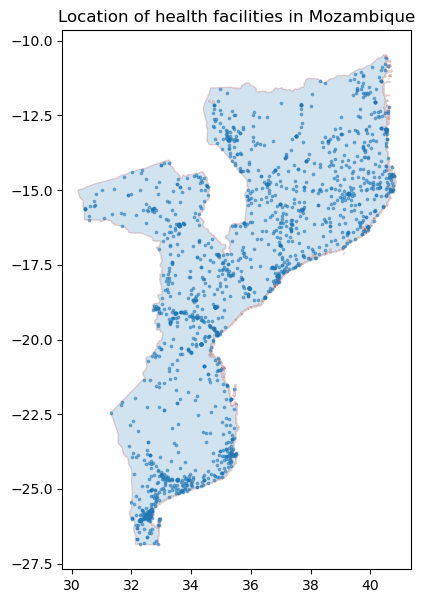

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
health_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Location of health facilities in Mozambique'.format(""))
plt.show()

### Importing Education Facilities

**Note** that for the code below to work properly, this should be a "Point" layer; in case the geometry is characterized as "Multipoint" you should convert it into a "Point" to proceed. You may use [Qgis](http://www.saga-gis.org/saga_tool_doc/3.0.0/shapes_points_15.html) to do this.

In [18]:
## Define the path and name of the file
messagebox.showinfo('OnSSET - post analysis', 'Select csv file with Education Facilities')
edu_path = filedialog.askopenfilename(filetypes = (("points",["*.csv"]),("all files","*.*")))

# Create a new geo-dataframe
edu_df = pd.read_csv(edu_path)   #### In case this does not read properly use: edu_df = pd.read_csv(edu_path, sep=',', encoding='latin-1')

In [19]:
print ("There are {} health facilities in the file you provided. Here is a preview:\n".format(edu_df.shape[0]))
edu_df.head(2)

There are 10563 health facilities in the file you provided. Here is a preview:



,Provincia,Distrito,Posto,Localidade,Povoado,Cod__Escola,NomeEsco_1,Type,Type_N,ZIP,...,Estado_de_Conservação3,Urinois,TotalUrino,UrinoisFun,Estado_de_Conservação4,CasaBanho,TotalCB,CBFunci,Longitude,Latitude
0,Niassa,Mandimba,Lissiete,Mitande,Capunda,70221,Escola Primária Completa de Lissiete,1.0,Primary,EPC Mississe,...,Bom,Sim,1.0,Sim,Bom,Sim,2,Sim,35.519389,-13.200889
1,Niassa,Muembe,Muembe,Lutuesase,Lutuesse,70725,Escola Primaria Completa de Lutuesse,1.0,Primary,EPC de Chinenge,...,Bom,Não,0.0,Não,Nenhum,Sim,7,Sim,35.519389,-13.200889


In [20]:
edu_df.columns

Index(['Provincia', 'Distrito', 'Posto', 'Localidade', 'Povoado',
       'Cod__Escola', 'NomeEsco_1', 'Type', 'Type_N', 'ZIP', 'Agua',
       'TipoFonte', 'QualiAgua', 'Energia', 'TipoEnergi', 'Latrina',
       'TotalLatri', 'Estado_de_Conservação3', 'Urinois', 'TotalUrino',
       'UrinoisFun', 'Estado_de_Conservação4', 'CasaBanho', 'TotalCB',
       'CBFunci', 'Longitude', 'Latitude'],
      dtype='object')

### Convert to a geodataframe

In [21]:
edu_gdf = gpd.GeoDataFrame(edu_df, geometry=gpd.points_from_xy(edu_df.Longitude,
                                                               edu_df.Latitude))

#### Cleaning EF dataset

In [22]:
## Fix unique ID column for future merge
#edu_gdf["Cod__Escola"] = edu_gdf["Cod__Escola"].replace("-", '', regex=True)
#edu_gdf["Cod__Escola"] = edu_gdf["Cod__Escola"].astype(float)

In [23]:
## Cleaning input df
edu_gdf = cleaning_string_attributes(edu_gdf, "Provincia")
edu_gdf = cleaning_string_attributes(edu_gdf, "Distrito")
edu_gdf = cleaning_string_attributes(edu_gdf, "Posto")
edu_gdf = cleaning_string_attributes(edu_gdf, "Localidade")
edu_gdf = cleaning_string_attributes(edu_gdf, "NomeEsco_1")
edu_gdf = cleaning_string_attributes(edu_gdf, "Povoado")
edu_gdf = cleaning_string_attributes(edu_gdf, "Agua")
edu_gdf = cleaning_string_attributes(edu_gdf, "TipoFonte")
edu_gdf = cleaning_string_attributes(edu_gdf, "QualiAgua")
edu_gdf = cleaning_string_attributes(edu_gdf, "Energia")
edu_gdf = cleaning_string_attributes(edu_gdf, "TipoEnergi")
edu_gdf = cleaning_string_attributes(edu_gdf, "Latrina")
edu_gdf = cleaning_string_attributes(edu_gdf, "Estado_de_Conservação3")
edu_gdf = cleaning_string_attributes(edu_gdf, "Urinois")
edu_gdf = cleaning_string_attributes(edu_gdf, "UrinoisFun")
edu_gdf = cleaning_string_attributes(edu_gdf, "Estado_de_Conservação4")
edu_gdf = cleaning_string_attributes(edu_gdf, "CasaBanho")
edu_gdf = cleaning_string_attributes(edu_gdf, "CBFunci")

In [24]:
# Adding an index column
edu_gdf['uid'] = range(1, len(edu_gdf)+1)

In [25]:
## Add school type as a name
schoolname = {1:"Primary",
              2: "Secondary",
              3: "Vocational",
              4: "Tertiary",
              5: "Tertiary"}

edu_gdf["Type_N"] = edu_gdf["Type"].map(schoolname)

In [26]:
## Remove no-coord sites; convert to geodf
edu_gdf =  edu_gdf[edu_gdf.Latitude.notnull()]
edu_gdf =  edu_gdf[edu_gdf.Longitude.notnull()]

edu_gdf = gpd.GeoDataFrame(edu_gdf, geometry=gpd.points_from_xy(edu_gdf.Longitude, 
                                                                edu_gdf.Latitude))

In [27]:
edu_gdf = edu_gdf[['uid',"Cod__Escola", "Type", "Type_N", "geometry"]]

In [28]:
## Use this in case you want to extract the filtered list of health facilities as a .gpkg
#output_path = r"Sample_Output"
#out_name = "MozEFMasterList.gpkg"
#edu_gdf.to_file(os.path.join(output_path,"{c}".format(c=out_name)), driver="GPKG")

#### ... and visualizing 

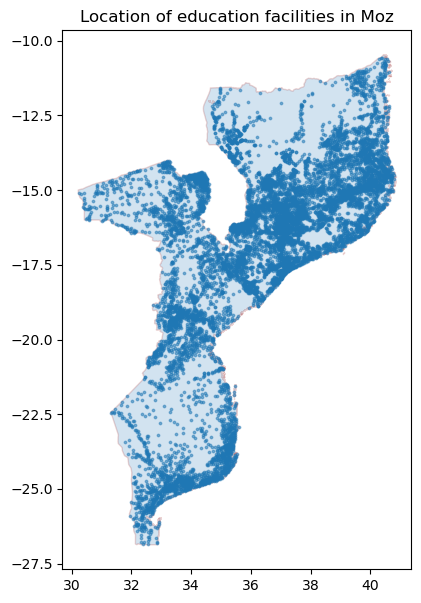

In [29]:
fig, ax = plt.subplots(figsize=(7, 7))

admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
edu_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Location of education facilities in Moz'.format(""))
plt.show()

### Importing population clusters (Calibrated Input file used in OnSSET)

In [30]:
## Define the path and name of the file
messagebox.showinfo('OnSSET - post analysis', 'Select the input file for OnSSET (clusters)')
clusters_path = filedialog.askopenfilename(filetypes = (("points",["*.csv"]),("all files","*.*")))

# Create a new geo-dataframe
clusters_df = pd.read_csv(clusters_path)

In [31]:
clusters_gdf = gpd.GeoDataFrame(clusters_df, geometry=gpd.points_from_xy(clusters_df.X_deg, clusters_df.Y_deg))
clusters_centroid = clusters_gdf

In [32]:
clusters_centroid.drop(["Unnamed: 0"], axis=1, inplace=True) 
clusters_centroid.drop(["level_0"], axis=1, inplace=True) 

In [33]:
print ('\n\033[1mNote!\033[0m\n\nThere are {} clusters in selected administrative area, where {:.0f} people reside.\nThese are served by {} health facilities.\n'.
       format(len(clusters_centroid), clusters_centroid.Pop.sum(), len(health_df)))


Note!

There are 726530 clusters in selected administrative area, where 30964077 people reside.
These are served by 1765 health facilities.



**Note: In case you already have a category/type specified for each Health Facility, you may proceed to step 3**

## Step 2. Characterizing HF & Predicting electricity requirements

You may select any of the above approaches to proceed.

## Health Facilities

In [34]:
HF = health_gdf

#### Plotting result of categorization

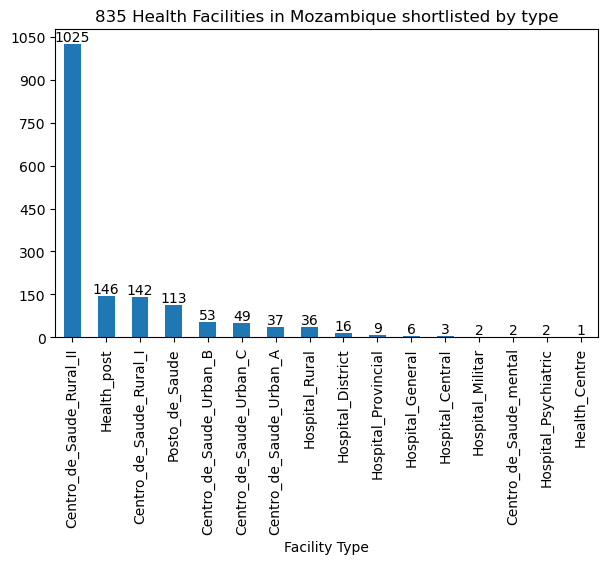

In [35]:
ax = HF['Facility Type'].value_counts().plot(kind='bar',figsize=[7,4])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Make some labels
rects = ax.patches
labels = [item for item in HF['Facility Type'].value_counts()]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.1, label,
            ha='center', va='bottom')


plt.title("835 Health Facilities in Mozambique shortlisted by type")
plt.show()

## Assign electricity requirements based on Category type

Similar to classification (see above) estimating electricity requirement per health facility is not an easy task considering the lack of quantitative, ground data. In this example, we use the [HOMER Powering Health Tool](https://poweringhealth.homerenergy.com/) interface to quantify potential electricity requirement (kWh/year) per type of health facility. The modeler can select the appropriate equipment and customize electricity targets accordingly. 

In [36]:
HF["Facility Type"].unique()

array(['Centro_de_Saude_Rural_II', 'Centro_de_Saude_Rural_I',
       'Hospital_Rural', 'Health_post', nan, 'Posto_de_Saude',
       'Centro_de_Saude_Urban_C', 'Hospital_Provincial',
       'Centro_de_Saude_Urban_B', 'Hospital_District',
       'Centro_de_Saude_Urban_A', 'Health_Centre', 'Hospital_Militar',
       'Centro_de_Saude_mental', 'Hospital_General', 'Hospital_Central',
       'Hospital_Psychiatric'], dtype=object)

In [37]:
# Previous method
# Rural dispensary - no inpatient - 4 emergency beds
HF.loc[(HF['Facility Type'] == "Health_post"), 'HF_kWh'] = 0.2*365  
HF.loc[(HF['Facility Type'] == "Posto_de_Saude"), 'HF_kWh'] = 0.2*365 
HF.loc[(HF['Facility Type'] == "Centro_de_Saude_Rural_I"), 'HF_kWh'] = 0.2*365      
HF.loc[(HF['Facility Type'] == "Centro_de_Saude_Rural_II"), 'HF_kWh'] = 5.7*365
HF.loc[(HF['Facility Type'] == "Centro_de_Saude_mental"), 'HF_kWh'] = 5.7*365
HF.loc[(HF['Facility Type'] == "Health_Centre"), 'HF_kWh'] = 5.7*365  
HF.loc[(HF['Facility Type'] == "Centro_de_Saude_Urban_A"), 'HF_kWh'] = 13.9*365                                                   
HF.loc[(HF['Facility Type'] == "Centro_de_Saude_Urban_B"), 'HF_kWh'] = 13.9*365
HF.loc[(HF['Facility Type'] == "Centro_de_Saude_Urban_C"), 'HF_kWh'] = 13.9*365                                                  
HF.loc[(HF['Facility Type'] == "Hospital_Rural"), 'HF_kWh'] = 37*365    
HF.loc[(HF['Facility Type'] == "Hospital_Hospital_Provincial"), 'HF_kWh'] = 37*365  
HF.loc[(HF['Facility Type'] == "Hospital_Militar"), 'HF_kWh'] = 37*365  
HF.loc[(HF['Facility Type'] == "Hospital_District"), 'HF_kWh'] = 37*365  
HF.loc[(HF['Facility Type'] == "Hospital_General"), 'HF_kWh'] = 37*365  
HF.loc[(HF['Facility Type'] == "Hospital_Central"), 'HF_kWh'] = 37*365  
HF.loc[(HF['Facility Type'] == "Hospital_Psychiatric"), 'HF_kWh'] = 37*365  
HF.loc[(HF['Facility Type'] == "nan"), 'HF_kWh'] = 5.7*365  

C:\Users\alexl\anaconda3\envs\moz_onsset_env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [38]:
print ('\n\033[1mNote!\033[0m\n\nThe estimated electricity demand for HF in the selected area, based on the above categorization, is ~{:.1f} kWh/year \n'.
       format(HF.HF_kWh.sum()))


Note!

The estimated electricity demand for HF in the selected area, based on the above categorization, is ~3751068.5 kWh/year 



## Education Facilities

In [39]:
EF = edu_gdf

In [40]:
EF.columns

Index(['uid', 'Cod__Escola', 'Type', 'Type_N', 'geometry'], dtype='object')

#### Plotting result of categorization

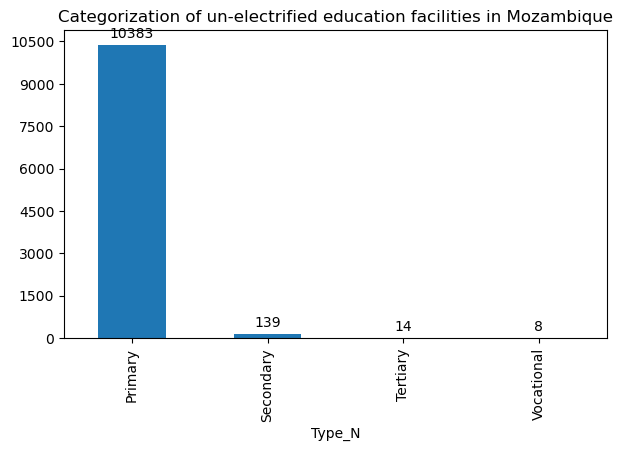

In [41]:
ax = EF['Type_N'].value_counts().plot(kind='bar',figsize=[7,4])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Make some labels
rects = ax.patches
labels = [item for item in EF['Type_N'].value_counts()]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+150, label,
            ha='center', va='bottom')

plt.title("Categorization of un-electrified education facilities in Mozambique")
plt.show()

## Assign electricity requirements based on Category type

Similar to classification (see above) estimating electricity requirement per health facility is not an easy task considering the lack of quantitative, ground data. The modeler can select the appropriate equipment and customize electricity targets accordingly. 

In [42]:
# Schools 
EF.loc[(EF['Type_N'] == "Primary"), 'EF_kWh'] = 2*365
EF.loc[(EF['Type_N'] == "Secondary"), 'EF_kWh'] = 7.7*365                                         
EF.loc[(EF['Type_N'] == "Tertiary"), 'EF_kWh'] = 145*365                           
EF.loc[(EF['Type_N'] == "Vocational"), 'EF_kWh'] = 4.5*365
EF.loc[(EF['Type_N'] == "nan"), 'EF_kWh'] = 4.5*365

In [43]:
print ('\n\033[1mNote!\033[0m\n\nThe estimated electricity demand for EF in the selected area, based on the above categorization, is ~{:.1f} kWh/year \n'.
       format(EF.EF_kWh.sum()))


Note!

The estimated electricity demand for EF in the selected area, based on the above categorization, is ~8724339.5 kWh/year 



# Step 3. Assign HF and EF target demand back to pop clusters

Electricity demand of each Health & Education Facility is assigned to the closest cluster.

(NNA code retrieved from [shakasom](https://github.com/shakasom/NearestNeighbour-Analysis))

In [44]:
## Simple function getting the nearest hub for a given set of points
#def calculate_nearest(row, destination, val, col="geometry"):
#    dest_unary = destination["geometry"].unary_union
#    nearest_geom = nearest_points(row[col], dest_unary)
#    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
#    match_value = match_geom[val].to_numpy()[0]
#    return match_value

In [45]:
### Source: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html
def get_nearest(src_points, candidates, k_neighbors=100):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=False)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # kilo meters
        closest_points['distance'] = dist * earth_radius / 1000

    return closest_points

In [46]:
#Function to change the order of columns in the dataframe 
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

## Health Facilities

In [47]:
HF.head(3)

,uid_Q001,Province,District,HF ID,Facility Type,geometry,index,HF_kWh
0,1021511.0,Cabo Delgado,Palma,288,Centro_de_Saude_Rural_II,POINT (40.50780 -10.59280),1,2080.5
1,1021506.0,Cabo Delgado,Palma,283,Centro_de_Saude_Rural_II,POINT (40.47310 -10.78080),2,2080.5
2,1021509.0,Cabo Delgado,Palma,286,Centro_de_Saude_Rural_II,POINT (40.58940 -10.85690),3,2080.5


#### Find nearest cluster

In [48]:
print(datetime.datetime.now())
#HF["id"] = HF.apply(calculate_nearest, destination=clusters_centroid, val="id", axis=1)  ## old sluggish function
closest_cluster_to_HF = nearest_neighbor(HF, clusters_centroid, return_dist=True)
print(datetime.datetime.now())

2025-07-10 12:58:35.953625
2025-07-10 12:58:51.743121


In [49]:
print(len(closest_cluster_to_HF), '==', len(HF))

1656 == 1656


In [50]:
closest_cluster_to_HF.head(2)

,level_0,index,fid,NightLights,Pop,Buildings,DEGURBA,GHI,TravelTimeMinutes,TravelTime,...,MinimumOverallLCOE2030,MinimumOverallCode2030,InvestmentCost2030,NewCapacity2030,ElecStatusIn2030,InvestmentCapita2030,FinalElecCode2030,ElecPop2030,geometry,distance
0,726486,726486,1076252,0.000,728.216,763,Rural Clusters,2079.0,247.0,4.116667,...,1.567295,8.0,24148.930244,1.763136,1,668.472983,8.0,833.135162,POINT (40.50894 -10.59581),0.284213
1,723878,723878,1073088,0.758,194.268,39,Suburban or Peri Urban,2048.0,268.0,4.466667,...,1.059023,3.0,14670.863105,1.956115,1,66.008391,3.0,222.257547,POINT (40.47124 -10.78734),0.590555


####  Join HF to the newly calculated dataframe

In [51]:
HF = HF.reset_index()
HF = HF.join(closest_cluster_to_HF[["id", "FinalElecCode2024"]])

In [52]:
HF.head(3)

,level_0,uid_Q001,Province,District,HF ID,Facility Type,geometry,index,HF_kWh,id,FinalElecCode2024
0,0,1021511.0,Cabo Delgado,Palma,288,Centro_de_Saude_Rural_II,POINT (40.50780 -10.59280),1,2080.5,1076252,99
1,1,1021506.0,Cabo Delgado,Palma,283,Centro_de_Saude_Rural_II,POINT (40.47310 -10.78080),2,2080.5,1073088,99
2,2,1021509.0,Cabo Delgado,Palma,286,Centro_de_Saude_Rural_II,POINT (40.58940 -10.85690),3,2080.5,1075987,99


In [55]:
## Use this in case you want to extract the list of health facilities with electrification status (from calibration) as a .gpkg
#output_path = r"Sample_Output"
#out_name = "MozHFMasterList_Calib.gpkg"
#HF.to_file(os.path.join(output_path,"{c}".format(c=out_name)), driver="GPKG")

#### Group by cluster id & delete other HF columns

In [54]:
HF_grouped_by_cluster = HF[["id", "HF_kWh"]].groupby(["id"]).sum()
HF_grouped_by_cluster.head(4)

,HF_kWh
id,
11,73.0
410,2080.5
719,2080.5
943,2080.5


#### Merge result to initial clusters

In [56]:
final_clusters_HF_kWh = HF_grouped_by_cluster.merge(clusters_gdf, how="outer", on='id')
final_clusters_HF_kWh["HF_kWh"] = final_clusters_HF_kWh["HF_kWh"].fillna(0)

In [57]:
print(final_clusters_HF_kWh.shape)
final_clusters_HF_kWh.head(2)

(726530, 144)


,id,HF_kWh,index,fid,NightLights,Pop,Buildings,DEGURBA,GHI,TravelTimeMinutes,...,MinimumOverall2030,MinimumOverallLCOE2030,MinimumOverallCode2030,InvestmentCost2030,NewCapacity2030,ElecStatusIn2030,InvestmentCapita2030,FinalElecCode2030,ElecPop2030,geometry
0,4,0.0,0,4,0.0,88.127,144,Low Density Rural,1919.0,309.0,...,SA_PV2030,1.130213,3.0,6948.211686,0.926428,1,68.914214,3.0,100.824072,POINT (31.46554 -22.47338)
1,5,0.0,1,5,0.0,6.339,14,Low Density Rural,1920.0,309.0,...,SA_PV2030,1.129625,3.0,499.526523,0.066604,1,68.878321,3.0,7.252304,POINT (31.47256 -22.47274)


In [58]:
final_clusters_HF_kWh.HF_kWh.sum()

3751068.5

## Education Facilities

#### Find nearest cluster

In [59]:
print(datetime.datetime.now())
#EF["id"] = EF.apply(calculate_nearest, destination=clusters_centroid, val="id", axis=1)  ## old sluggish function 
closest_cluster_to_EF = nearest_neighbor(EF, clusters_centroid, return_dist=True)
print(datetime.datetime.now())

2025-07-10 12:59:10.780429
2025-07-10 12:59:28.714639


In [60]:
print(len(closest_cluster_to_EF), '==', len(EF))

10544 == 10544


####  Join EF to the newly calculated dataframe

In [61]:
EF = EF.reset_index()
EF = EF.join(closest_cluster_to_EF[["id", "FinalElecCode2024"]])

In [62]:
EF.head(3)

,index,uid,Cod__Escola,Type,Type_N,geometry,EF_kWh,id,FinalElecCode2024
0,0,1,70221,1.0,Primary,POINT (35.51939 -13.20089),730.0,549033,99
1,1,2,70725,1.0,Primary,POINT (35.51939 -13.20089),730.0,549033,99
2,2,3,70857,1.0,Primary,POINT (35.38314 -14.00681),730.0,521623,99


In [64]:
## Use this in case you want to extract the list of education facilities with electrification status (from calibration) as a .gpkg
#output_path = r"Sample_Output"
#out_name = "MozEFMasterList_Calib.gpkg"
#EF.to_file(os.path.join(output_path,"{c}".format(c=out_name)), driver="GPKG")

#### Group by cluster id & delete other EF columns

In [65]:
EF_grouped_by_cluster = EF[["id", "EF_kWh"]].groupby(["id"]).sum()
EF_grouped_by_cluster.head(4)

,EF_kWh
id,
10,730.0
11,730.0
41,730.0
71,730.0


#### Merge result to initial clusters

In [66]:
final_clusters_HF_EF_kWh = EF_grouped_by_cluster.merge(final_clusters_HF_kWh, how="outer", on='id')
final_clusters_HF_EF_kWh["EF_kWh"] = final_clusters_HF_EF_kWh["EF_kWh"].fillna(0)

In [67]:
print(final_clusters_HF_EF_kWh.shape)
final_clusters_HF_EF_kWh.head(2)

(726530, 145)


,id,EF_kWh,HF_kWh,index,fid,NightLights,Pop,Buildings,DEGURBA,GHI,...,MinimumOverall2030,MinimumOverallLCOE2030,MinimumOverallCode2030,InvestmentCost2030,NewCapacity2030,ElecStatusIn2030,InvestmentCapita2030,FinalElecCode2030,ElecPop2030,geometry
0,4,0.0,0.0,0,4,0.0,88.127,144,Low Density Rural,1919.0,...,SA_PV2030,1.130213,3.0,6948.211686,0.926428,1,68.914214,3.0,100.824072,POINT (31.46554 -22.47338)
1,5,0.0,0.0,1,5,0.0,6.339,14,Low Density Rural,1920.0,...,SA_PV2030,1.129625,3.0,499.526523,0.066604,1,68.878321,3.0,7.252304,POINT (31.47256 -22.47274)


##  Cleaning and assigning HF and EF demand to proper columns

In [68]:
final_clusters_HF_EF_kWh["HealthDemand"] = final_clusters_HF_EF_kWh["HF_kWh"]
final_clusters_HF_EF_kWh["EducationDemand"] = final_clusters_HF_EF_kWh["EF_kWh"]

In [69]:
print ("Health Demand:", final_clusters_HF_EF_kWh.HealthDemand.sum(), "==", HF.HF_kWh.sum())
print ("Education Demand:", final_clusters_HF_EF_kWh.EducationDemand.sum(), "==", EF.EF_kWh.sum())

Health Demand: 3751068.5 == 3751068.5
Education Demand: 8724339.5 == 8724339.5


------------------------------------------------------------------------------------

# Step 4. Export the updated Population cluster dataset with Social demand

In [70]:
messagebox.showinfo('OnSSET - post analysis', 'Browse to the directory and name the updated input file')
output_file = filedialog.asksaveasfilename()
final_clusters_HF_EF_kWh.to_csv(output_file + '.csv', index=False)

### Extras..

In [96]:
print("As per IEP calibration, there are {} electrified HF as in 2024. That is {:.1f}% of all facilities".format(
    HF[HF["FinalElecCode2024"] != 99]["id"].count(),
    (HF[HF["FinalElecCode2024"] != 99]["id"].count() / health_df.shape[0]) * 100
)) 

print("\nFrom those, we estimate that {} are powered by EDM and {} from off-grid solutions (mini-grids)".format(
    HF[HF["FinalElecCode2024"] == 1]["id"].count(),
    HF[HF["FinalElecCode2024"] == 8]["id"].count()))


As per IEP calibration, there are 436 electrified HF as in 2024. That is 24.7% of all facilities

From those, we estimate that 394 are powered by EDM and 42 from off-grid solutions (mini-grids).


In [75]:
HF_grouped_by_district = HF.groupby(["Province", "FinalElecCode2024"]).count()
HF_grouped_by_district["Facility Type"]

Province                        FinalElecCode2024
Cabo Delgado                    1                     39
                                8                      2
                                99                    67
Gaza                            1                     42
                                8                      3
                                99                    88
Inhambane                       1                     20
                                8                      4
                                99                    98
Manica                          1                     38
                                8                      7
                                99                    60
Maputo Cidade                   1                      5
                                99                    26
Maputo Provincia                1                     19
                                8                      2
                                99    

In [77]:
# Assuming df is your DataFrame
grouped_HF_district = HF.groupby(["District", "Facility Type"]).size().reset_index(name='count')
grouped_HF_district

,District,Facility Type,count
0,Alto Molocue,Centro_de_Saude_Rural_II,11
1,Alto Molocue,Centro_de_Saude_Urban_B,3
2,Alto Molocue,Health_post,2
3,Alto Molocue,Hospital_Rural,1
4,Ancuabe,Centro_de_Saude_Rural_I,4
...,...,...,...
416,Zavala,Centro_de_Saude_Rural_II,9
417,Zavala,Health_post,1
418,Zumbo,Centro_de_Saude_Rural_I,1
419,Zumbo,Centro_de_Saude_Rural_II,5


In [73]:
# Assuming df is your DataFrame
grouped_HF_district = HF.groupby(["FinalElecCode2024"]).size().reset_index(name='count')
grouped_HF_district

,FinalElecCode2024,count
0,1,394
1,8,42
2,99,1220


In [74]:
# Assuming df is your DataFrame
grouped_EF_district = EF.groupby(["FinalElecCode2024"]).size().reset_index(name='count')
grouped_EF_district

,FinalElecCode2024,count
0,1,662
1,8,37
2,99,9845
